In [19]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from PIL import Image
from xml.etree import ElementTree as ET

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations = self.load_annotations()

    def __getitem__(self, idx):
        # Load image and annotations
        img_path = os.path.join(self.root, 
                                'sfrs_' + self.annotations[idx]['filename'][2], 
                                self.annotations[idx]['filename'][:-7], 
                                self.annotations[idx]['filename'])
        
        img = Image.open(img_path).convert("L")
        target = self.annotations[idx]['annotation']
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target

    def __len__(self):
        return len(self.annotations)

    def load_annotations(self):
        annotations = []
        # Parse XML files
        for root, dirs, files in os.walk(self.root):
            for xml_file in files:
                if xml_file.endswith(".xml"):
                    tree = ET.parse(os.path.join(root, xml_file))
                    root = tree.getroot()
                    annotation = {
                        'filename': root.find('filename').text,
                        'annotation': {
                            'boxes': [],
                            'labels': []
                        }
                    }
                    for obj in root.findall('object'):
                        box = obj.find('bndbox')
                        xmin = int(box.find('xmin').text)
                        ymin = int(box.find('ymin').text)
                        xmax = int(box.find('xmax').text)
                        ymax = int(box.find('ymax').text)

                        annotation['annotation']['boxes'].append([xmin, ymin, xmax, ymax])
                        annotation['annotation']['labels'].append(int(obj.find('name').text))

                    annotations.append(annotation)

        return annotations

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = CustomDataset(root='../data/data', transforms=transform)

In [4]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
# NOTE THAT I AM USING THIS TO SPEED UP THE DEV
sampler = torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=6)

In [6]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=2,
                           # shuffle=True,
                             num_workers=0,
                          sampler=sampler
                         )
val_loader = DataLoader(val_dataset, batch_size=2,
                         shuffle=False,
                           num_workers=0
                        )

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
# Define the optimizer and the learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
# Define the training loop
def training_loop(num_epochs): 
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            targets = []
            for i in range(2):
                d = {}
                d['boxes'] = torch.tensor([b[i] for b in labels['boxes'][0]]).unsqueeze(0)
                d['labels'] = torch.tensor([labels['labels'][0][i]])
                targets.append(d)
                
            output = model(images, targets)
            losses = sum(loss for loss in output.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # Update the learning rate
        lr_scheduler.step()
    print(epoch)
    torch.save(model, '../models/findbox.pth')

In [11]:
# Run the training
training_loop(10)

9


In [12]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0,i].imshow(np.asarray(img))
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

tensor([0.7872])


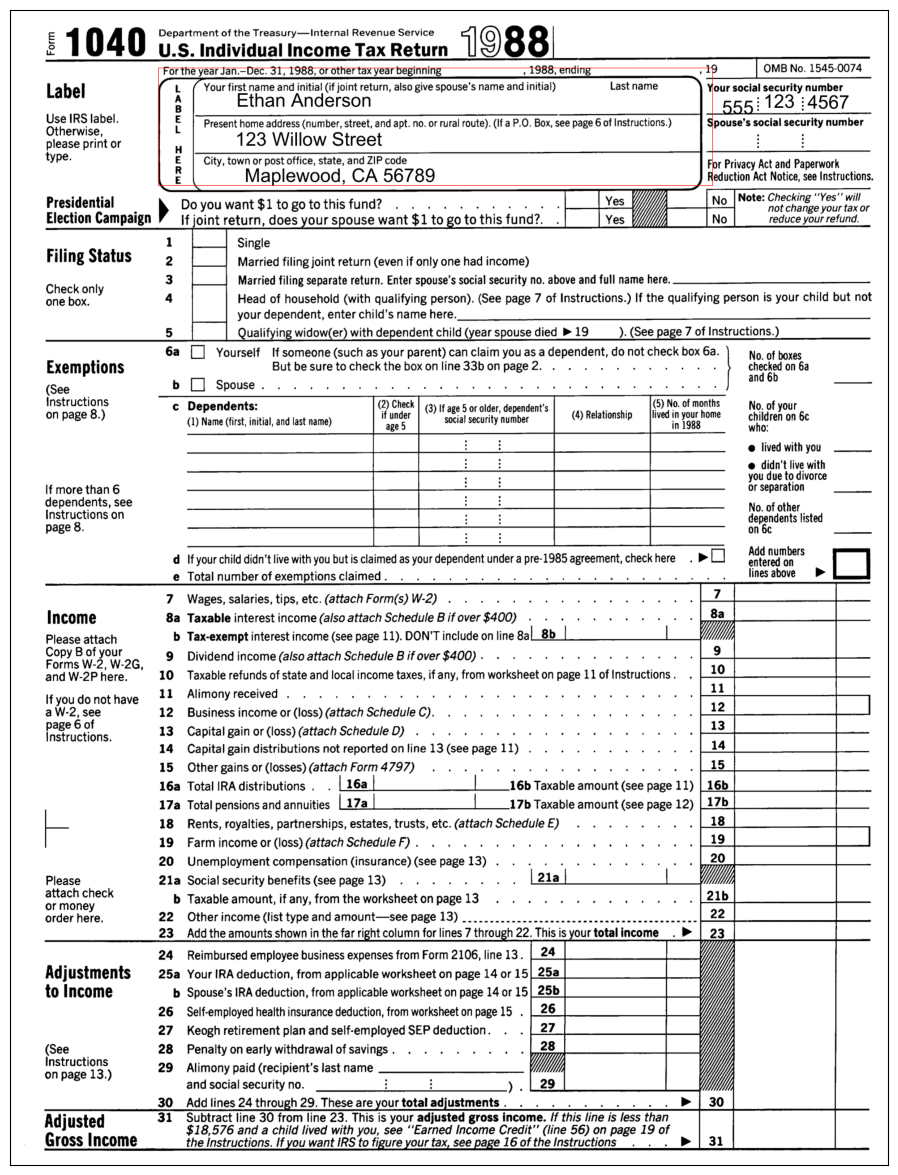

In [26]:
# define a function to test a new image
def test_model(img_path):
    model = torch.load('../models/findbox.pth')
    model.eval()
    original_img = Image.open(img_path).convert("L")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform(original_img).unsqueeze(0)
    output = model(img)
    boxes = output[0]['boxes'].detach().cpu()
    labels = output[0]['labels'].detach().cpu()
    scores = output[0]['scores'].detach().cpu()

    # find the box with the highest condifence score
    max_score_idx = torch.argmax(scores)
    boxes = boxes[max_score_idx].unsqueeze(0)
    scores = scores[max_score_idx].unsqueeze(0)

    # Convert image into Tensor of shape (C x H x W) and dtype uint8
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(original_img)
    output_image = draw_bounding_boxes(image=img_tensor, boxes=boxes, colors=(255, 0, 0))
    print(scores)
    show(output_image)

    return boxes, scores

result_box = test_model('../data/test_form.png')



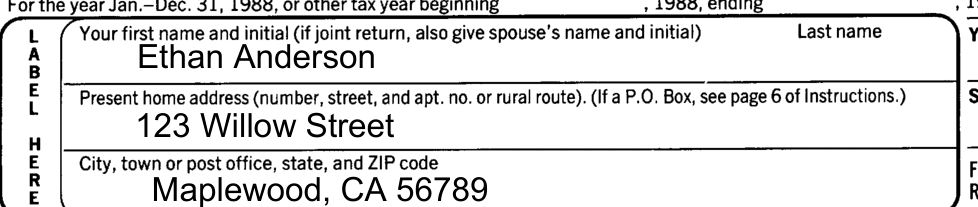

In [27]:
def cropImage(img_path, box):
    img = Image.open(img_path).convert("L")
    box = tuple(box[0].tolist())
    img = img.crop(box)
    img.save('../data/cropped.png')
    display(img)

cropped_img = cropImage("../data/test_form.png", result_box[0])

In [31]:
import easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext('../data/cropped.png')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [32]:
for text in result:
    print(text)

([[5, 0], [189, 0], [189, 15], [5, 15]], 'For Ine year Jan -uec', 0.5704104318168363)
([[195, 0], [501, 0], [501, 17], [195, 17]], '314988, or otner tax year Deginning', 0.19821825815041075)
([[653, 0], [765, 0], [765, 15], [653, 15]], '1500 enuinb', 0.18857382169941053)
([[76, 20], [704, 20], [704, 48], [76, 48]], "Your first name and initial (if joint return, also give spouse's name and initial)", 0.8081538115884691)
([[795, 21], [885, 21], [885, 41], [795, 41]], 'Last name', 0.8466255566492036)
([[134, 39], [381, 39], [381, 75], [134, 75]], 'Ethan Anderson', 0.9854728567964026)
([[27, 45], [43, 45], [43, 99], [27, 99]], '1', 0.6755026765093)
([[76, 84], [378, 84], [378, 110], [76, 110]], 'Present home address (number, street,', 0.8158999249673518)
([[410, 84], [910, 84], [910, 110], [410, 110]], 'apt. no. or rural route). (Ifa P.O. Box, see page 6 of Instructions )', 0.502192891537943)
([[133, 109], [401, 109], [401, 145], [133, 145]], '123 Willow Street', 0.7523487901845495)
([[27,